# NeSI Hackathon 2020

https://github.com/nesi/nzrse_hackathon_2020/

K. Wilson

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

In [3]:
export_train_preds = False
export_test_preds = False

## Data
Assumptions about the data:
1. Rows with a zero target variable value (`core_hours`) are invalid and can be removed.
2. All other rows are jobs which ran to natural completion.
3. Variance in the target variable for rows with the same input feature values is caused by current cluster (GPFS) load. This load is not captured in the dataset. See further comments at the bottom.

In [4]:
data_X = pd.read_csv('../data/emod3d_train_x.csv')  
data_y = pd.read_csv('../data/emod3d_train_y.csv')
data_X_test = pd.read_csv('../data/emod3d_test_x.csv')  

In [5]:
assert data_X.isnull().values.any() == False
assert data_y.isnull().values.any() == False
assert data_X_test.isnull().values.any() == False

## Features
Model performance was baselined on the raw features and engineered features added through trial and error against reducing the validation set's `quantile loss`. See further comments at the bottom. 

Raw data features:
1. nx, ny and nz represent the number of grid points in each direction in the domain (the finite difference simulation has a uniform grid).
2. nt is the number of time steps the simulation is run for.
3. n_sub is the number of sub faults used to represent the earthquake source (a measure of complexity of the fault being simulated).
4. n_cores is the number of cluster cores.

In [44]:
# variations on job size and compute
data_X['b'] = minmax_scale(data_X['nx']*data_X['ny']*data_X['nz']*data_X['nt'])
data_X['b_log'] = np.log(data_X['nx']*data_X['ny']*data_X['nz']*data_X['nt'])
data_X['a'] = (data_X['nx']*data_X['ny']*data_X['nz'])/data_X['nt']
data_X['k'] = (data_X['n_sub']/data_X['n_cores'])

# apply also to the test set
data_X_test['b'] = minmax_scale(data_X_test['nx']*data_X_test['ny']*data_X_test['nz']*data_X_test['nt'])
data_X_test['b_log'] = np.log(data_X_test['nx']*data_X_test['ny']*data_X_test['nz']*data_X_test['nt'])
data_X_test['a'] = (data_X_test['nx']*data_X_test['ny']*data_X_test['nz'])/data_X_test['nt']
data_X_test['k'] = (data_X_test['n_sub']/data_X_test['n_cores'])

# the selection of features feels a bit artibrary, but objectively generates the smallest loss 
# with the selected estimator.
features = ['ny','b','nt','n_cores','n_sub','b_log','a','k']

## Dataset
Remove rows where core_hours=0 from the training set (none are expected in test set).

In [7]:
tmp_data = data_X.copy()
tmp_data['core_hours'] = data_y.core_hours
tmp_data = tmp_data[tmp_data.core_hours != 0]
data_X = tmp_data.loc[:, data_X.columns]
data_y = tmp_data.loc[:, data_y.columns]

In [8]:
assert len(tmp_data[tmp_data['core_hours']==0]) == 0

In [9]:
# 80:20 random split
X_train, X_validation, y_train, y_validation  = train_test_split(data_X, data_y, 
                                                                 test_size=0.20, random_state=42, 
                                                                 shuffle=True)

In [10]:
# Supplied loss function
def quantile_loss(y_actual, y_predict):
    """
    Cost function to minimise
    - y_actual: the actual number of core hours consumed by the simulation (array-like)
    - y_predict: the model's prediction (array-like of same length as above)
    - returns positive number, the lower the better
    """
    quantile = 0.9
    errors = np.maximum((y_actual - y_predict) * quantile, (y_predict - y_actual) * (1.0 - quantile))
    return np.mean(errors)

## Model
Eleven estimators were evaluated, including a neural net, with `RandomForestRegressor` having the lowest loss. The `GradientBoostingRegressor` achieved similar, but slighly larger loss. Hyperparameters were evaluated using `GridSearchCV`.

In [11]:
clf =  RandomForestRegressor(n_estimators=90, max_depth=30, random_state=42,
                                      max_features="sqrt",
                                      min_samples_split=2,
                                      bootstrap=True,
                                      max_leaf_nodes=None,
                                      min_samples_leaf=1)

clf.fit(X_train[features], y_train.values.ravel())

RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=90,
                      random_state=42)

In [12]:
# Get predictions on the training and validation sets
y_preds_train = clf.predict(X_train[features])
y_preds_train = y_preds_train.reshape(len(y_preds_train),1)
q_loss_train = quantile_loss(y_train, y_preds_train)

y_preds_val = clf.predict(X_validation[features])
y_preds_val = y_preds_val.reshape(len(y_preds_val),1)
q_loss_val = quantile_loss(y_validation, y_preds_val)

q_loss_train.mean(), q_loss_val.mean()

(1.1441049299270842, 0.7147673980155395)

## Interpretation

In [13]:
# leaves vs datapoints
clf.estimators_[0].get_n_leaves(), len(X_train)

(873, 9436)

In [14]:
feature_importance_df = pd.DataFrame(features, columns=['Feature'])
feature_importance_df['Importance'] = clf.feature_importances_
feature_importance_df.sort_values('Importance', ascending=False, inplace=True)
feature_importance_df = feature_importance_df.head(20)
feature_importance_df

,Feature,Importance
0,ny,0.218523
5,b_log,0.205210
1,b,0.194500
2,nt,0.147660
3,n_cores,0.073802
4,n_sub,0.070699
6,a,0.063116
7,k,0.026489


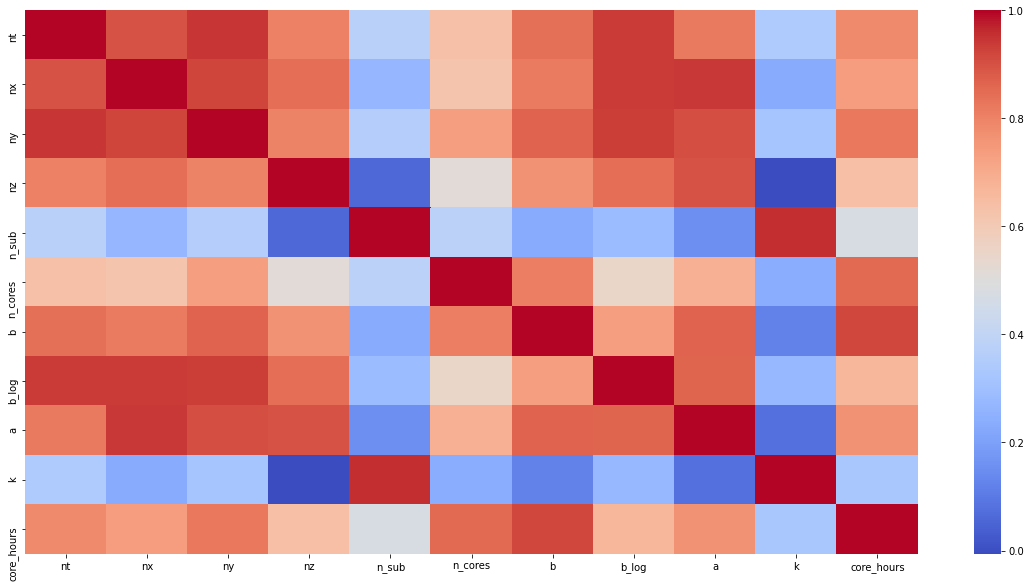

In [41]:
# full training set (includes validation set)
plt.figure(figsize=(20,10))
sns.heatmap(data=tmp_data.corr(), cmap='coolwarm')
plt.show()

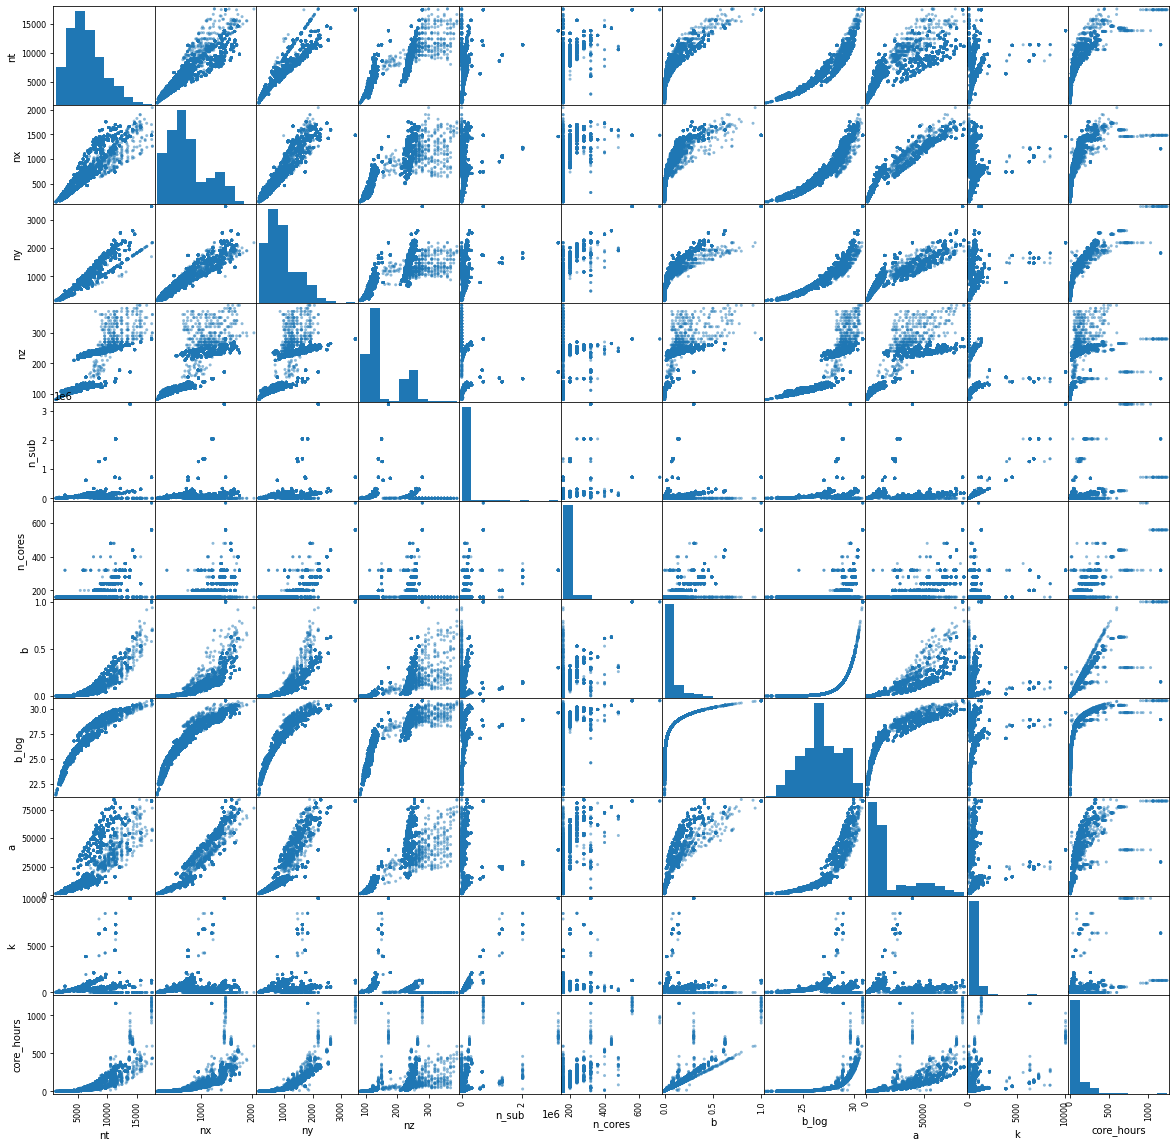

In [16]:
# full training set (includes validation set)
scatter_matrix(tmp_data, figsize=(20,20))
plt.show()

In [17]:
# the training data is small so can be easier to view in excel
tmp = X_train.copy()
tmp['core_hours'] = y_train
tmp['core_hours_pred'] = y_preds_train
tmp['%change'] = (y_preds_train - y_train)/y_train * 100
    
if(export_train_preds):    
    tmp.to_csv('../output/train_preds.csv',index=True)


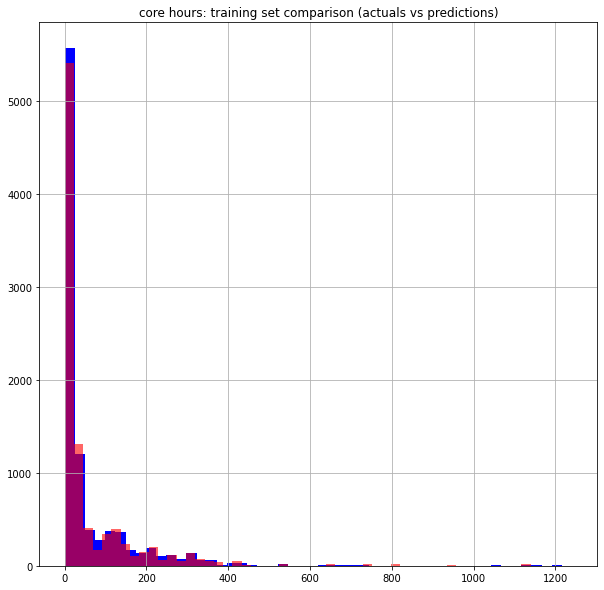

In [18]:
tmp['core_hours'].hist(figsize=(10, 10),bins=50, color='b')
tmp['core_hours_pred'].hist(figsize=(10, 10),bins=50, color='r', alpha=0.6)
plt.title('core hours: training set comparison (actuals vs predictions)')
plt.show()

## Looking at specific rows (from the training set predictions)

In [34]:
# worst over prediction in the training set
# this row is an outlier in a set of 18 rows with the same feature values (see: Variance in target variable)
worst_over = tmp [tmp['%change'] == tmp['%change'].max()]
worst_over['core_hours'].max(), worst_over['core_hours_pred'].max()

(31.11111111111111, 819.608712826322)

In [37]:
# worst under prediction in the training set
worst_under = tmp [tmp['%change'] == tmp['%change'].min()]
worst_under['core_hours'].min(), worst_under['core_hours_pred'].min()

(6.8, 3.701657283485284)

In [43]:
# avg prediction error in the training set
tmp['core_hours'].mean(), tmp['core_hours_pred'].mean(), tmp['%change'].mean()

(65.57531910885027, 65.63014405706991, 0.8768262074708143)

## Variance in the target variable
The dataset contains rows which may not have run to completion and rows which vary in duration due to external factors i.e. due to load on the cluster when the job executes the actual `core_hours` can vary significantly. Meaning, the dataset is missing relevant info which would help improve predictions.

In [49]:
# for rows with the same feature values and variance in the target variable, around the mean is predicted.
# e.g. rows with 720 n_cores are the same with a target variable range (900.4 to 989.4 core hours)
mask720 = (tmp['n_cores'] == 720)
tmp.loc[mask720].sort_values(by='core_hours', ascending=False)

,nt,nx,ny,nz,n_sub,n_cores,b,b_log,a,k,core_hours,core_hours_pred,%change
17,17455.0,1481.0,3487.0,280.0,721875,720.0,1.0,30.859441,82840.971641,1002.604167,989.4,953.377145,-3.640879
9471,17455.0,1481.0,3487.0,280.0,721875,720.0,1.0,30.859441,82840.971641,1002.604167,972.0,953.377145,-1.915932
10618,17455.0,1481.0,3487.0,280.0,721875,720.0,1.0,30.859441,82840.971641,1002.604167,969.4,953.377145,-1.652863
6963,17455.0,1481.0,3487.0,280.0,721875,720.0,1.0,30.859441,82840.971641,1002.604167,932.2,953.377145,2.271738
7695,17455.0,1481.0,3487.0,280.0,721875,720.0,1.0,30.859441,82840.971641,1002.604167,900.4,953.377145,5.883734


## Export test set predictions

In [20]:
if(export_test_preds):
    y_preds_test = clf.predict(data_X_test[features])
    tst = pd.DataFrame()
    tst['core_hours_pred'] = y_preds_test
    tst.to_csv('../output/emod3d_test_y.csv',index=False)


# Fin